## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

## Imports and Parameters

In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import torch
print(torch.cuda.is_available())

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [ ]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 10
Ky = 10
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 2000     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 784     # input units
Nc = 10        # number of classes
val_split = 1/6

In [ ]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")
# device="cpu"

In [ ]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

In [ ]:
# move data from and to gpu

def detach(tensor):
    try:
        return tensor.cpu().detach().numpy()
    except:
        return tensor
    
def attach(tensor):
    try:
        return torch.from_numpy(tensor).float().to(device)
    except:
        return tensor

## Data
Let's load the data from `keras`:
- Use `keras.datasets.mnist.load_data()` to load the 60000 train and 10000 test samples.
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 784) and labels to (#samples, 10)
- Split the train part to 50000 train and 10000 validation samples

In [ ]:
# Cell derived from this page: https://keras.io/examples/vision/mnist_convnet/

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# reshape to (# samples, 784)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]* x_test.shape[2])

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

In [ ]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [ ]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]))
    yy=0
    HM=np.zeros((Kw*Ky,Kw*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw].reshape(Kw,Kw)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    
    if ax is not None:
        im = ax.imshow(HM, cmap='bwr', vmin=-nc, vmax = nc)
        fig.colorbar(im, ticks=[np.amin(HM), 0, np.amax(HM)], ax=ax)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
        plt.axis('off')
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [ ]:
def forward(inputs, synapses, p, N_in, N_hid, N_batch, training=True):
    inputs = torch.transpose(inputs, 0, 1)
    sig = torch.sign(synapses).to(device)
    
    # with p=2, this is equal to <W.v> = I 
    tot_input = torch.mm(sig*torch.abs(synapses).pow(p-1), inputs)
    
    if training == False:
        return torch.transpose(tot_input, 0, 1)
    
    y = torch.argsort(tot_input, dim=0).to(device) # using tot_input (I) as proxy for h
    y1 = torch.zeros((N_hid, N_batch)).to(device)  # g(Q)
    
    y1[y[N_hid-1, :], np.arange(N_batch)] = 1.0    # g(max_activation in I) = 1
    y1[y[N_hid-k], np.arange(N_batch)] = -delta    # g(second max activation) = -0.4
    
    xx = torch.sum(torch.mul(y1, tot_input), 1)    # g(Q) * <W, v>

    ds = torch.matmul(y1, torch.transpose(inputs, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, N_in), synapses)
    nc = torch.max(torch.abs(ds))
    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

## GPU Implementation of the Unsupervised Training

In [ ]:
def train_weights(x_train, N_hid, N_batch, Nep=Nep, mu=0, sigma=1, device="cpu"):
    # move train data to cuda
    N_train, N_in = x_train.shape
    x_train = attach(x_train)
    synapses = (torch.randn(N_hid, N_in) * sigma + mu).to(device)
    eps0 = torch.tensor(4e-2).to(device)

    for nep in range(Nep):
        eps=eps0*(1-nep/Nep)

        for i in range(N_train//N_batch):
            inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
            ds, nc = forward(inputs, synapses, p, N_in, N_hid, N_batch)
            
            if nc < prec:
                nc = prec
            synapses += torch.mul(torch.div(ds, nc), eps)
        
        if (nep % 5) == 0:
            print('epoch ', nep)    
#         draw_weights(synapses.cpu().detach().numpy(), Kx, Ky)
    
    return synapses

In [ ]:
# %matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
print('using device: {}'.format(device))
start = time.time()

synapses = train_weights(attach(x_train), N_hid, N_batch, Nep, device=device).to(device)

print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1ZEHI4yCa8ZqrwySM5_3jy-bcIenlUuA4/view?usp=sharing)


In [ ]:
import os
weights_dir = 'weights'


os.makedirs(weights_dir, exist_ok=True)

params = 'MNIST_synapses_hid{}_epoch{}_eps{}_p{}_k{}_batch{}'.format(N_hid, N_hid, eps0, p, k, N_batch)

# load a pre-trained model
synapses_dir = os.path.join(weights_dir, \
                            params + '.npy')

# to load synapses
synapses = np.load(synapses_dir)

# to save synapses
# np.save(synapses_dir, synapses)

In [ ]:
%matplotlib inline
synapses = detach(synapses)

fig=plt.figure(figsize=(20, 10))
draw_weights(synapses, Kx*2, Ky*2)

plt.tight_layout()
plt.show()

### Looking at the weights
Weights seem to be mostly positive. Let's see if that's the case numerically!

In [ ]:
synapses.min()
syn_list = synapses.ravel()
# nonzero_syn = np.array([g for g in syn_list if g != 0]) 
# np.median(gg)
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

In [ ]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

### Let's look at the weights distribution 

In [ ]:
%matplotlib inline


plt.figure(figsize=(15,7))
plt.ylim(0, 100)
plt.hist(np.delete(synapses, 0).ravel(), bins=500)
plt.show()

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [ ]:
# a utility function to normalize inputs
def normalize(x):
    x_norm = x - np.mean(x, axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return attach(x_norm)

In [ ]:
# Center and normalize input data to unit vectors  
synapses = attach(synapses)
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_in, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_in, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_in, N_hid, N_test, training=False)


In [ ]:
# convert everything to numpy tensors
x_hid_train = detach(x_hid_train)
x_hid_val = detach(x_hid_val)
x_hid_test = detach(x_hid_test)

n=4.5
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n
x_hid_test = (x_hid_test * (x_hid_test>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [ ]:
bio_model = keras.Sequential([
    layers.Dense(Nc, input_shape=(N_hid,)),
#     layers.BatchNormalization(),
    layers.Activation('softmax')
])

print(bio_model.summary())

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(lr=1e-1)

bio_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_test, y_test), batch_size=1000, epochs=100, verbose=1)

### Save a model

In [ ]:
model_dir = os.path.join('models', params)
bio_model.save(model_dir)

### Load a model

In [26]:
model_dir = os.path.join('models', params)
bio_model = keras.models.load_model(model_dir)

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [ ]:
bp_model = keras.Sequential([
    layers.Dense(N_hid, input_shape=(N_in,)),
#     layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
bp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1000, epochs=100, verbose=1)

In [28]:
bp_model.save(model_dir+"BP")
bp_model = keras.models.load_model(model_dir+"BP")

## Plot losses and accuracies

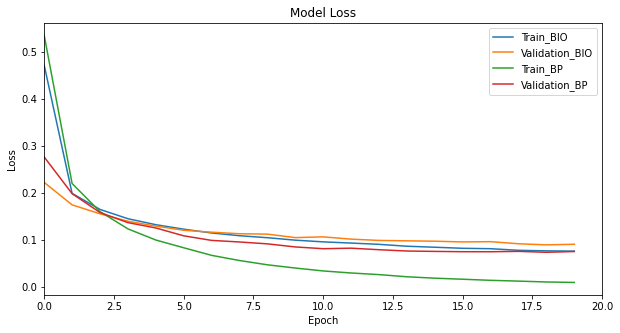

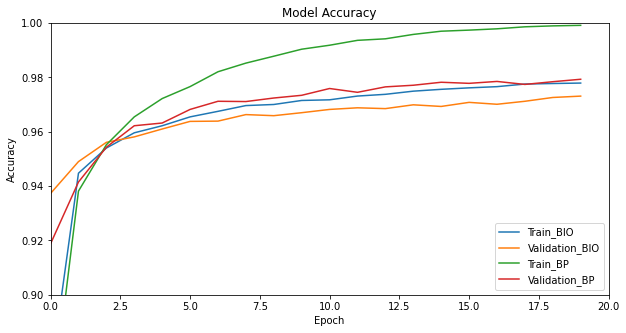

In [32]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 20)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(.9, 1)
plt.xlim(0, 20)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

In [33]:
print('BIO best validation accuracy:', max(bio_history['val_acc']))
print('BP best validation accuracy:', max(bp_history['val_acc']))

BIO best validation accuracy: 0.9731000065803528
BP best validation accuracy: 0.9792999982833862


## Plot weights of the BP model

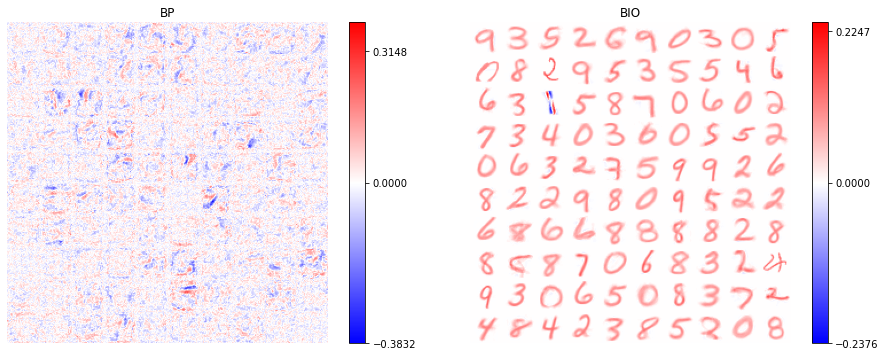

In [34]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(detach(synapses), Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [ ]:
control_model = keras.Sequential([
    layers.Dense(Nc, input_shape=(N_in,), activation='softmax')
])
control_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=1000, epochs=20, verbose=1)

In [40]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.9327400016784668
Final Validation Accuracy: 0.914300000667572


## Train a second hidden layer
The goal is to have two hidden layers, each having 100 neurons.

In [41]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
plt.tight_layout()
# print(x_hid_train.shape)
# device='cpu'
synapses_2 = train_weights(attach(x_hid_train), N_hid, N_batch=N_batch, Nep=50)

epoch  0
epoch  5
epoch  10
epoch  15
epoch  20
epoch  25
epoch  30
epoch  35
epoch  40
epoch  45


<Figure size 1080x720 with 0 Axes>

In [ ]:
# Center and normalize input data to unit vectors  
x_train1 = normalize(x_hid_train)
x_val1 = normalize(x_hid_val)
x_test1 = normalize(x_hid_test)

x_hid_train2 = forward(x_train1, synapses_2, p, N_train, training=False)
x_hid_val2 = forward(x_val1, synapses_2, p, N_val, training=False)
x_hid_test2 = forward(x_test1, synapses_2, p, N_val, training=False)

n=2
x_hid_train2 = (x_hid_train2 * (x_hid_train2>0)) ** n
x_hid_val2 = (x_hid_val2 * (x_hid_val2>0)) ** n

In [ ]:
bio_model2 = keras.Sequential([
    layers.Dense(Nc, input_shape=(N_hid,)),
    layers.BatchNormalization(),
    layers.Activation('softmax')
])
print(bio_model2.summary())
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs2 = bio_model2.fit(x_hid_train2, y_train, validation_data=(x_hid_val2, y_val), batch_size=100, epochs=100, verbose=1)

## Next steps
**Update 19.12.2021**: We couldn't reproduce the paper results with 100 hidden neurons. We noticed that the paper uses 2000 hidden neurons, so we used a hidden layer of size 1000 (since 2000 would take too much time). This took about 12 hours to train on my local machine (Intel Core-i7-4702MQ, 16GB RAM). This is pretty much impractical and incomparable with the training of the BP-based model in terms of efficiency. One idea is to see if two hidden layers of lower size will increase accuracy while lowering the training time.  

### short-term 
- ~~load data from keras (MNIST)~~
- ~~add a softmax layer to train the netwok (SGD, ...)~~
- ~~get the network run on a simple validation set~~
- ~~get the accuracy ...~~
- fine-tune bio model to get the best result
- ~~add a second hidden layer~~
- ~~visualize all hidden neurons~~
- ~~distrtibution of the weights~~
- check the range of the weights (they're currently not consistent w the paper) 
- clean the notebooks
- merge the gpu code inside the notebooks. 
- merging our git branches
- make a backup from our local repositories. 

### long-term
- ~~get the result from the bio network~~
- ~~train a "usual" net~~
- ~~compare the results~~
- ~~visualize the weights in the backprop-based network~~
- do the bio computation on gpu?
- ~~do the unsupervised part on a _faces_ dataset (alternative: fashion-mnist)~~
 

### challenge
- BP model converges with far fewer hidden neurons (let's find out the minimum number of hidden neurons in BP where it still outperforms BIO model).
- Currently our BIO model is not performing on the same level as reported in the paper.